# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from sklearn.decomposition import PCA

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1490.27it/s]


In [24]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

In [25]:
len(preprocessed_reviews)

4986

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.

preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:02<00:00, 1889.18it/s]


In [27]:
final['preprocessed_reviews'] = pd.Series(preprocessed_reviews,index=final.index)

In [28]:
final['Text'][1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [29]:
final['preprocessed_reviews'][1]

'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted not sure error vendor intended represent product jumbo'

# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


In [31]:
final_counts[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## [4.2] Bi-Grams and n-Grams.

In [32]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [33]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [34]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [35]:
len(list_of_sentance)

4986

In [36]:
W2V = Word2Vec(list_of_sentance,min_count=1)

C:\Users\91910\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [37]:
print(W2V)

Word2Vec(vocab=13015, size=100, alpha=0.025)


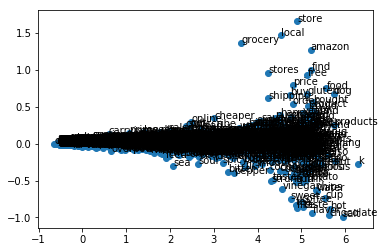

In [38]:
#https://datascience.stackexchange.com/questions/10695/how-to-initialize-a-new-word2vec-model-with-pre-trained-model-weights

# fit a 2d PCA model to the vectors

X = W2V[W2V.wv.vocab]
pca = PCA(n_components=2)

result = pca.fit_transform(X)

# create a scatter plot of the projection


plt.scatter(result[:,0],result[:,1])

words = list(W2V.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()


In [39]:
W2V.save('W2V.bin')

In [40]:
W2V.similarity('woman', 'man')

0.99606186

In [41]:
final_w2v = list(W2V.wv.vocab)

final_w2v

['product',
 'available',
 'victor',
 'traps',
 'unreal',
 'course',
 'total',
 'fly',
 'genocide',
 'pretty',
 'stinky',
 'right',
 'nearby',
 'used',
 'bait',
 'seasons',
 'ca',
 'not',
 'beat',
 'great',
 'received',
 'shipment',
 'could',
 'hardly',
 'wait',
 'try',
 'love',
 'slickers',
 'call',
 'instead',
 'stickers',
 'removed',
 'easily',
 'daughter',
 'designed',
 'signs',
 'printed',
 'reverse',
 'use',
 'car',
 'windows',
 'beautifully',
 'print',
 'shop',
 'program',
 'going',
 'lot',
 'fun',
 'everywhere',
 'surfaces',
 'like',
 'tv',
 'screens',
 'computer',
 'monitors',
 'really',
 'good',
 'idea',
 'final',
 'outstanding',
 'decals',
 'window',
 'everybody',
 'asks',
 'bought',
 'made',
 'two',
 'thumbs',
 'glad',
 'cocker',
 'standard',
 'poodle',
 'puppy',
 'loves',
 'stuff',
 'trust',
 'brand',
 'superior',
 'nutrition',
 'compare',
 'labels',
 'previous',
 'feed',
 'pedigree',
 'mostly',
 'corn',
 'little',
 'dude',
 'healthy',
 'happy',
 'high',
 'energy',
 'gloss

In [42]:
len(final_w2v)

13015

In [43]:
W2V.wv['seasons']

array([-0.00775847,  0.01284706,  0.05344873,  0.04760043,  0.01850532,
       -0.013935  ,  0.0325854 , -0.03137348, -0.01015735,  0.01537968,
        0.00053319, -0.04114015, -0.04433013,  0.01160847,  0.0178278 ,
       -0.01995532,  0.02199253, -0.01221445, -0.02704587, -0.03208524,
       -0.00863215, -0.01652746,  0.00287412, -0.03501154,  0.06460188,
        0.01599106,  0.02404067,  0.00643322,  0.00288097,  0.01369777,
        0.02889437,  0.07110558,  0.03228446,  0.03871313, -0.00232246,
       -0.02555293,  0.02924207,  0.05234521,  0.02509419, -0.01651051,
       -0.02508155,  0.01358235,  0.00560075, -0.0005466 ,  0.05399818,
       -0.02717612,  0.00237094, -0.04648356,  0.00669062, -0.0067387 ,
        0.05450562,  0.03518974,  0.02458115,  0.00413405, -0.00689047,
       -0.00218385,  0.00486433,  0.02355609,  0.09597994, -0.04058841,
        0.02908799,  0.02590417,  0.01367355, -0.0202156 ,  0.07882868,
       -0.03926345, -0.04920141,  0.00795368, -0.02766028, -0.05

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [44]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in final_w2v:
            #print(word)
            vec = W2V.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:13<00:00, 357.44it/s]


4986
100


In [45]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [46]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in final_w2v and word in tfidf_feat:
            vec = W2V.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [01:03<00:00, 79.10it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

{2: 257021.61052572308, 5: 249154.82263053287, 8: 243061.47544653094, 11: 240639.88030350313, 14: 236798.7732010438, 17: 235061.1529359026}


No handles with labels found to put in legend.


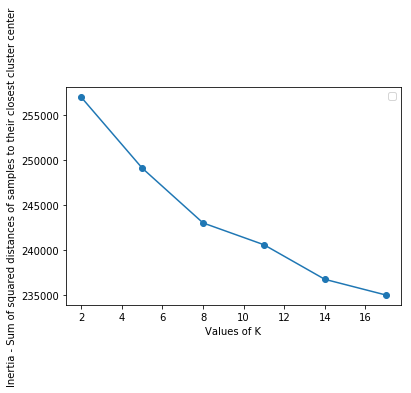

In [70]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
SSE = {}

for k in range(2,20,3):
    Kmeans = KMeans(n_clusters=k).fit(final_counts)
    SSE[k] = Kmeans.inertia_
    
print(SSE)   
plt.plot(list(SSE.keys()),list(SSE.values()),"-o")
plt.legend()
plt.xlabel('Values of K')
plt.ylabel('Inertia - Sum of squared distances of samples to their closest cluster center')
plt.show()

In [ ]:
#Based on the elbow curve,I would like to select 8 as the best number of clusters

In [71]:
#sorted(SSE, key=SSE.get)
sorted(SSE.items(), key=lambda x: x[1])



[(17, 235061.1529359026),
 (14, 236798.7732010438),
 (11, 240639.88030350313),
 (8, 243061.47544653094),
 (5, 249154.82263053287),
 (2, 257021.61052572308)]

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [72]:
# Please write all the code with proper documentation
Kmeans = KMeans(n_clusters=8).fit(final_counts)
predicted = Kmeans.predict(final_counts)

final['Predicted_cluster_BOW'] = predicted


In [73]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews,Predicted_cluster_BOW,Predicted_cluster_TFIDF
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...,1,30
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...,1,20
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...,1,30
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...,1,30
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...,glad cocker standard poodle puppy loves stuff ...,1,28


In [74]:
final['Predicted_cluster_BOW'].value_counts()

1    3486
2    1091
6     121
3     108
0     102
7      76
5       1
4       1
Name: Predicted_cluster_BOW, dtype: int64

Plotting worcloud for Cluster No 1 (with most reviews being clustered) and 3 (cluster containing medium range of reviews)

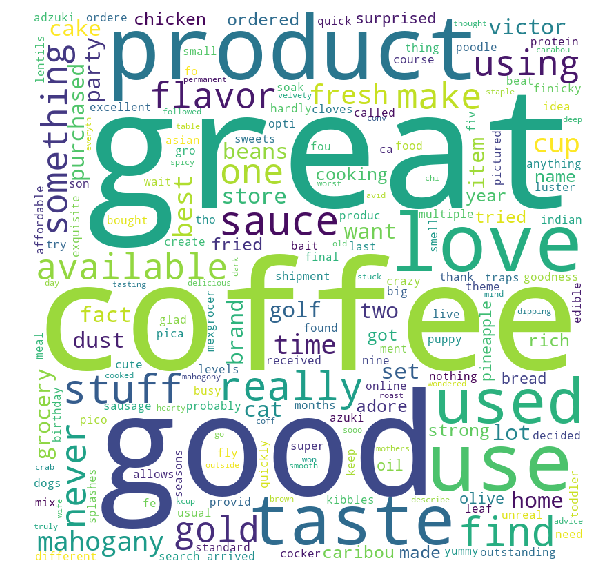

In [75]:
from wordcloud import WordCloud, STOPWORDS 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Predicted_cluster_BOW']==1)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

We see that words like Coffe,good,great,product are dominant while words like taste,mahogany,available are mildly dominant and some others like proteins.lentils,seasons could hardly find their presence in the wordcloud.The  bigger and bolder the words,the more is the frequency.

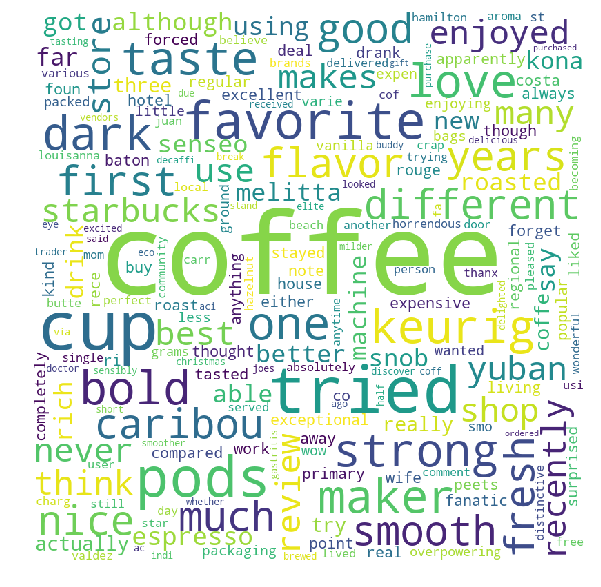

In [76]:
from wordcloud import WordCloud, STOPWORDS 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Predicted_cluster_BOW']==3)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#We see that words like Coffe,favorite,cup,tried are dominant while words like although,espresso,smooth are mildly dominant and some others like packaging,served,wife could hardly find their presence in the wordcloud.The bigger and bolder the words,the more the frequency.

# [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

{2: 4815.6045958404675, 5: 4728.590253908948, 8: 4670.5331199095135, 11: 4641.59110767285, 14: 4615.605557188626, 17: 4584.490834277172}


No handles with labels found to put in legend.


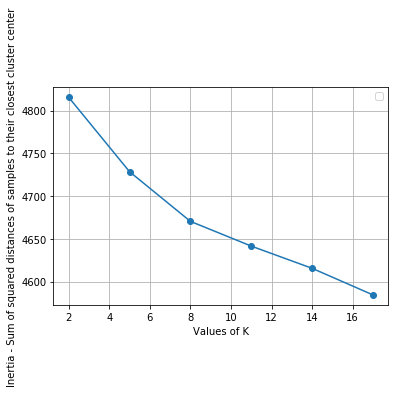

In [81]:
SSE2 = {}

for k in range(2,20,3):
    Kmeans = KMeans(n_clusters=k).fit(final_tf_idf)
    SSE2[k] = Kmeans.inertia_
    
print(SSE2) 
plt.grid()
plt.plot(list(SSE2.keys()),list(SSE2.values()),"-o")
plt.legend()
plt.xlabel('Values of K')
plt.ylabel('Inertia - Sum of squared distances of samples to their closest cluster center')
plt.show()

In [60]:
#Based on Elbow Curve I would like to keep 8


In [82]:
sorted(SSE2.items(), key=lambda x: x[1])

[(17, 4584.490834277172),
 (14, 4615.605557188626),
 (11, 4641.59110767285),
 (8, 4670.5331199095135),
 (5, 4728.590253908948),
 (2, 4815.6045958404675)]

In [62]:
#pd.Series(Kmeans.labels_).value_counts()

In [83]:
# Please write all the code with proper documentation
Kmeans_tfidf = KMeans(n_clusters=8).fit(final_tf_idf)


predicted_tfidf = Kmeans_tfidf.predict(final_tf_idf)

final['Predicted_cluster_TFIDF'] = predicted_tfidf

#final.drop(labels='Predicted_BOW',axis=1,inplace=True)


In [84]:
final['Predicted_cluster_TFIDF'].value_counts()

3    2282
0     832
6     458
2     321
5     285
7     281
4     265
1     262
Name: Predicted_cluster_TFIDF, dtype: int64

Plotting worcloud for Cluster No 3 (with most reviews being clustered) and 6 (cluster containing medium range of reviews)

# [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

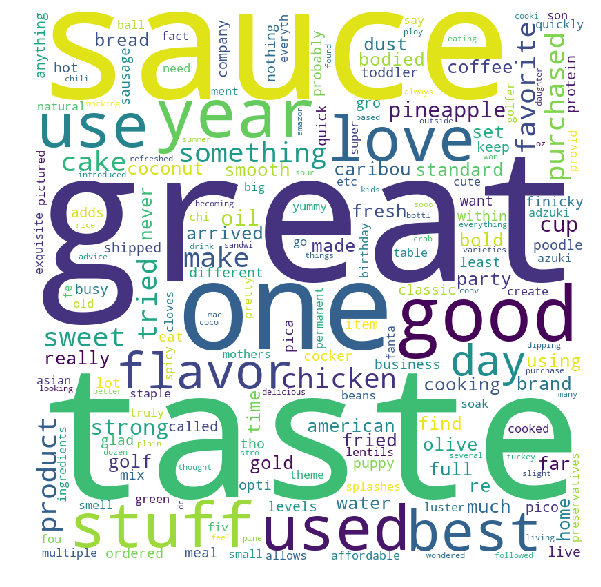

In [85]:
from wordcloud import WordCloud, STOPWORDS 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Predicted_cluster_TFIDF']==3)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

Observations:
We see that words like taste,great,sauce,one are dominant while words like product,espresso,cake are mildly dominant and some others like affordable,shipped,lentils could hardly find their presence in the wordcloud.The bigger and bolder the words,the more the frequency.

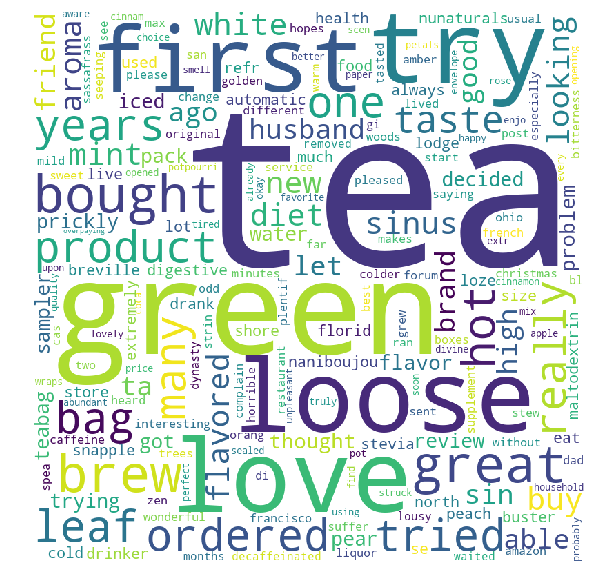

In [86]:
from wordcloud import WordCloud, STOPWORDS 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Predicted_cluster_BOW']==6)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

{2: 893.7604243674651, 5: 299.6705818717312, 8: 177.20047239786587, 11: 138.70489766722494, 14: 114.52795782990134, 17: 99.89988519215117}


No handles with labels found to put in legend.


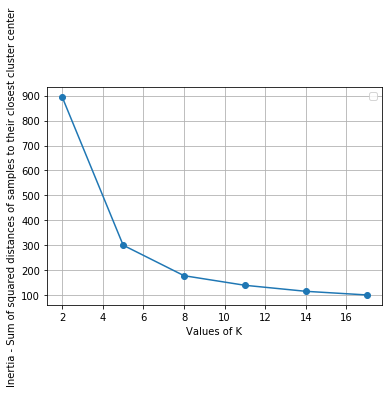

In [87]:
# Please write all the code with proper documentation

sent_vectors2 = np.array(sent_vectors)
SSE3 = {}

for k in range(2,20,3):
    Kmeans = KMeans(n_clusters=k).fit(sent_vectors2)
    SSE3[k] = Kmeans.inertia_
    
print(SSE3) 
plt.grid()
plt.plot(list(SSE3.keys()),list(SSE3.values()),'-o')
plt.legend()
plt.xlabel('Values of K')
plt.ylabel('Inertia - Sum of squared distances of samples to their closest cluster center')
plt.show()

In [151]:
# Please write all the code with proper documentation# Please write all the code with proper documentation
Kmeans_avgW2V = KMeans(n_clusters=8).fit(sent_vectors2)


predicted_avgW2V = Kmeans_avgW2V.predict(sent_vectors2)

final['Predicted_cluster_avgW2V'] = predicted_avgW2V

#final.drop(labels='Predicted_BOW',axis=1,inplace=True)

#final.head()

#print(sorted(final['preprocessed_reviews'].groupby(final['Predicted_cluster_TFIDF']).count(),reverse=True))

#final['preprocessed_reviews'].groupby(final['Predicted_cluster_TFIDF']).count()


In [152]:
final['Predicted_cluster_avgW2V'].value_counts()

3    1095
1    1030
7     989
4     675
0     653
2     269
6     259
5      16
Name: Predicted_cluster_avgW2V, dtype: int64

Reviews are nicely distributed among different clusters with cluster 3 and 1 containing most of them and 5 containing least of them.

# [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

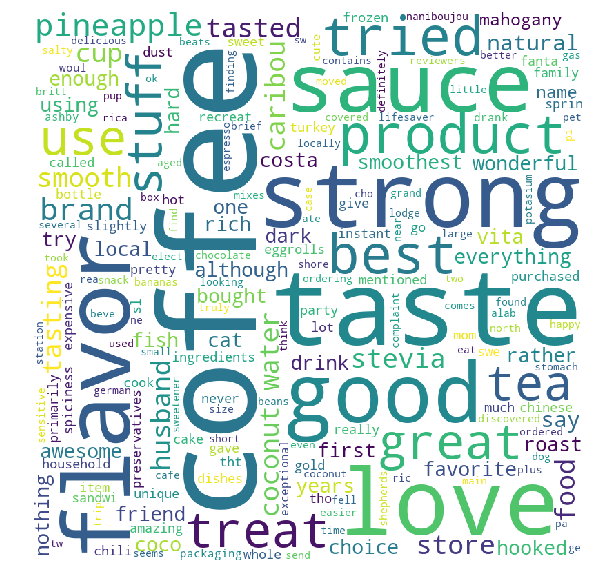

In [153]:
from wordcloud import WordCloud, STOPWORDS 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Predicted_cluster_avgW2V']==3)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

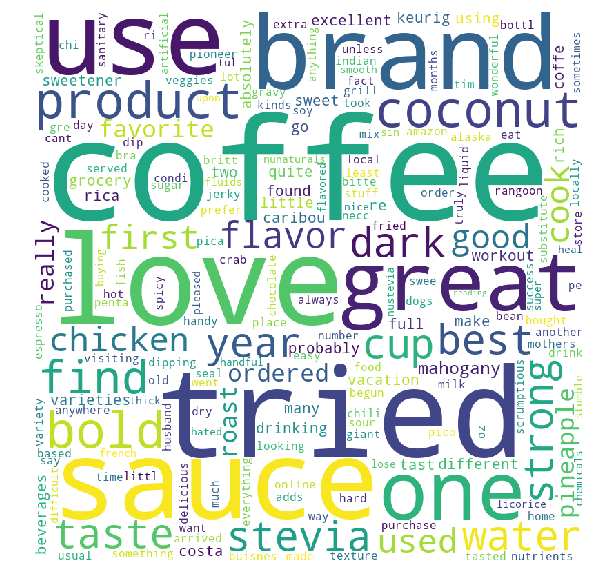

In [154]:
from wordcloud import WordCloud, STOPWORDS 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Predicted_cluster_avgW2V']==7)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

{2: 1127.2875891064853, 5: 371.1732764723394, 8: 219.62684000619677, 11: 168.5972754306478, 14: 137.65727943005015, 17: 117.37035426760367}


No handles with labels found to put in legend.


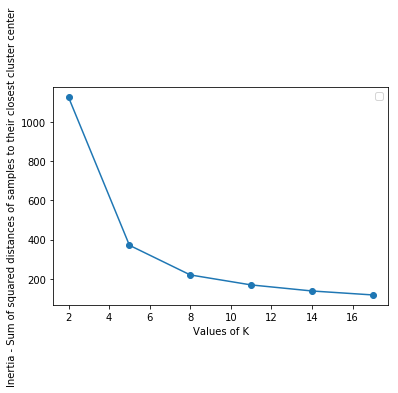

In [156]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tfidf_sent_vectors2 = np.array(tfidf_sent_vectors)
from sklearn.cluster import KMeans
SSE4 = {}

for k in range(2,20,3):
    Kmeans = KMeans(n_clusters=k).fit(tfidf_sent_vectors2)
    SSE4[k] = Kmeans.inertia_
    
print(SSE4)   
plt.plot(list(SSE4.keys()),list(SSE4.values()),'-o')
plt.legend()
plt.xlabel('Values of K')
plt.ylabel('Inertia - Sum of squared distances of samples to their closest cluster center')
plt.show()


In [ ]:
sorted(SSE4.items(), key=lambda x: x[1])


In [157]:
Kmeans_tfidfW2V = KMeans(n_clusters=8).fit(tfidf_sent_vectors2)
predicted_tfidfW2V = Kmeans_tfidfW2V.predict(tfidf_sent_vectors2)

final['Predicted_cluster_tfidfW2V'] = predicted_tfidfW2V


#final.head()

print(final['Predicted_cluster_tfidfW2V'].value_counts())

0    1036
2     999
6     880
1     714
3     710
5     317
4     314
7      16
Name: Predicted_cluster_tfidfW2V, dtype: int64


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

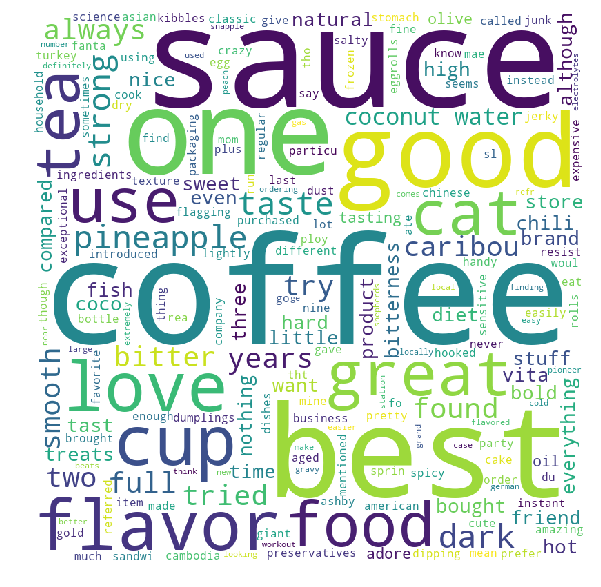

In [158]:
# Please write all the code with proper documentation

from wordcloud import WordCloud, STOPWORDS 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Predicted_cluster_tfidfW2V']==0)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 



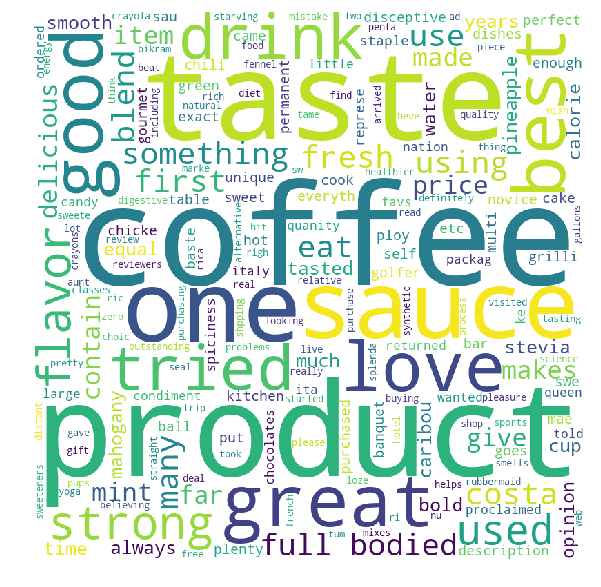

In [159]:
from wordcloud import WordCloud, STOPWORDS 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Predicted_cluster_tfidfW2V']==6)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

 <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>

In [161]:
# Please write all the code with proper documentation
#We do not have the task of finding the best number of cluster for this case as its quite exasperating to find the best number of cluster.
#Dendogram method could be used for the purpose but it wouldn't serve the purpose as it could make the use case a little bit complicated.
#For now we would go with trial method and select different number of clusters and plot wordcloud for each

from sklearn.cluster import AgglomerativeClustering

Agg_avgW2V = AgglomerativeClustering(n_clusters=2)
Agg_avgW2V.fit(sent_vectors2)

predicted_Agg_avgW2V = Agg_avgW2V.labels_

final['Cluster_Agg_avgW2V'] = predicted_Agg_avgW2V


In [162]:
final['Cluster_Agg_avgW2V'].value_counts()

0    3284
1    1702
Name: Cluster_Agg_avgW2V, dtype: int64

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

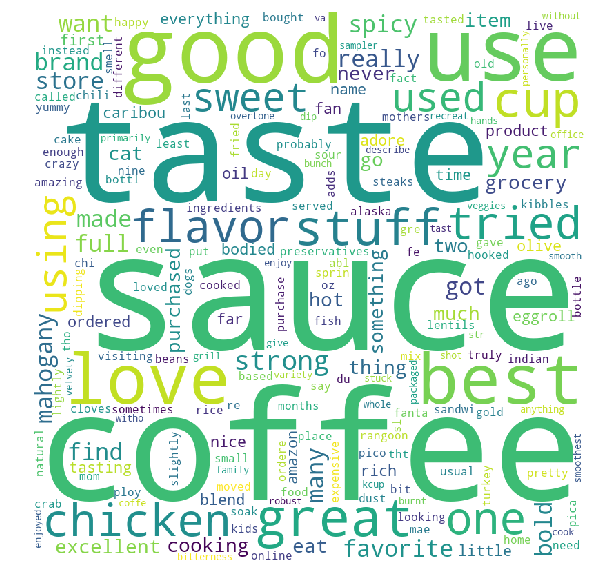

In [163]:
# Please write all the code with proper documentation

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Cluster_Agg_avgW2V']==0)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

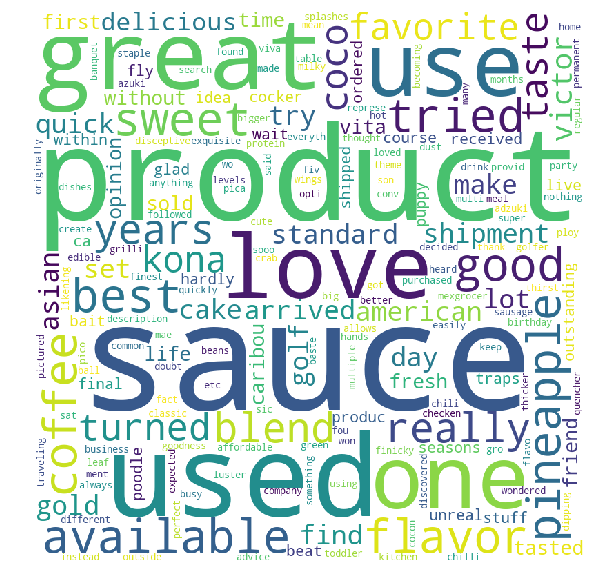

In [164]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Cluster_Agg_avgW2V']==1)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [166]:
# Please write all the code with proper documentation

Agg_tfidfW2V = AgglomerativeClustering(n_clusters=5)
Agg_tfidfW2V.fit(tfidf_sent_vectors2)

predicted = Agg_tfidfW2V.labels_

final['Cluster_Agg_tfidfW2V'] = predicted

In [167]:
final['Cluster_Agg_tfidfW2V'].value_counts()

2    1715
3    1115
4     935
0     663
1     558
Name: Cluster_Agg_tfidfW2V, dtype: int64

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

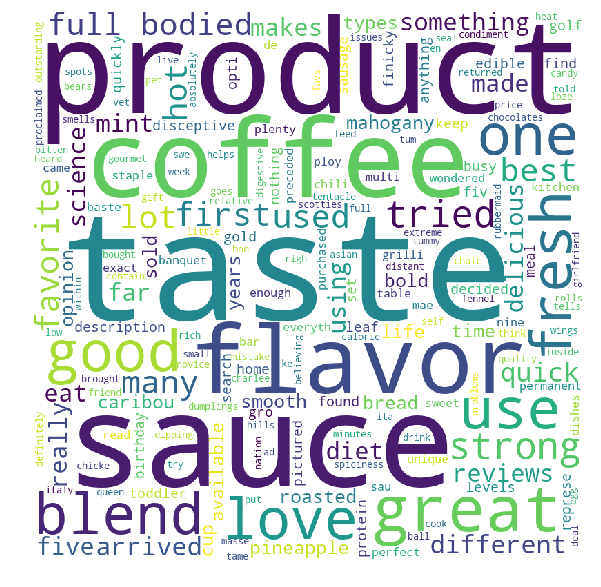

In [168]:
# Please write all the code with proper documentation
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Cluster_Agg_tfidfW2V']==3)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

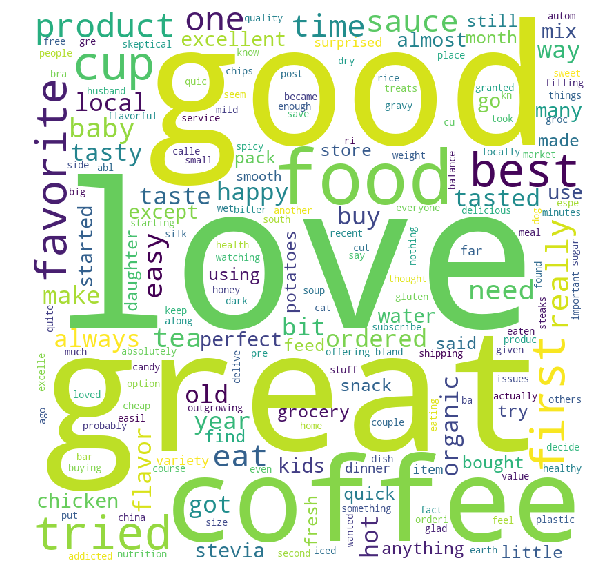

In [169]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Cluster_Agg_tfidfW2V']==1)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [137]:
# Standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False)
sent_vectors2_std = std.fit_transform(sent_vectors2)

In [143]:
# Please write all the code with proper documentation
#using Nearest neighbors technique to calculate eps value.
#took 50 as n_neighbors (other value could also be taken but chose it based on approximation).We are considering 5000 reviews and chosing eps based on 50 nearest neighbors seems to be fine for now
#
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=50)
nbrs = neigh.fit(sent_vectors2_std)
d, i= nbrs.kneighbors(sent_vectors2_std)


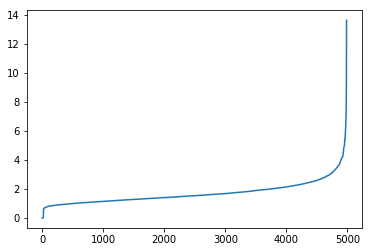

In [144]:
#plotting the distance obtained and chosing best eps using elbow method
distance = np.sort(d, axis=0)
distance = distance[:,1]
plt.plot(distance)

In [145]:
#Chose 3 as the eps value based on above elbow curve
from sklearn.cluster import DBSCAN

DBSCAN_avgW2V = DBSCAN(eps=3)
DBSCAN_avgW2V.fit(sent_vectors2_std)

predicted = DBSCAN_avgW2V.labels_

final['Cluster_DBSCAN_avgW2V'] = predicted

In [146]:
final['Cluster_DBSCAN_avgW2V'].value_counts()

 0    4560
-1     395
 1      15
 4       6
 3       4
 2       3
 5       3
Name: Cluster_DBSCAN_avgW2V, dtype: int64

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

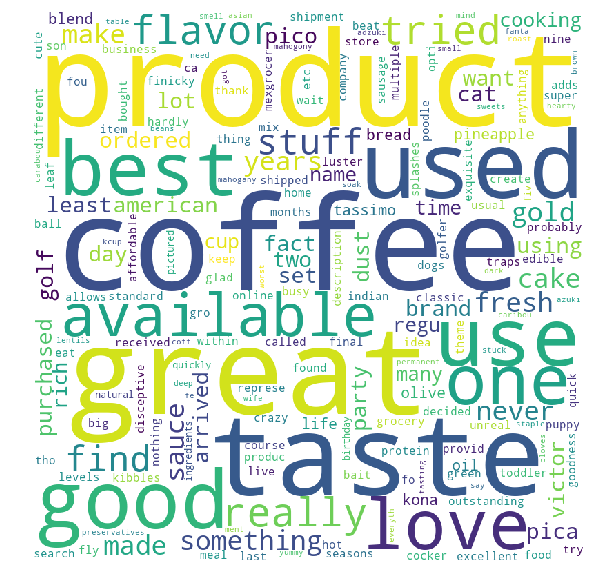

In [147]:
# Please write all the code with proper documentation
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Cluster_DBSCAN_avgW2V']==0)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#Observation :
Most of the data points are clustered in Cluster 0
There are few noisy points as we can see the cluster no -1

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [170]:
# Standardization
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False)
tfidf_sent_vectors2_std = std.fit_transform(tfidf_sent_vectors2)

In [177]:
# Please write all the code with proper documentation
#using Nearest neighbors technique to calculate eps value.
#took 30 as n_neighbors (other value could also be taken but chose it based on approximation).We are considering 5000 reviews and chosing eps based on 30 nearest neighbors seems to be fine for now
#
from sklearn.neighbors import NearestNeighbors
neigh1 = NearestNeighbors(n_neighbors=50)
nbrs1 = neigh1.fit(tfidf_sent_vectors2_std)
d1, i= nbrs1.kneighbors(tfidf_sent_vectors2_std)

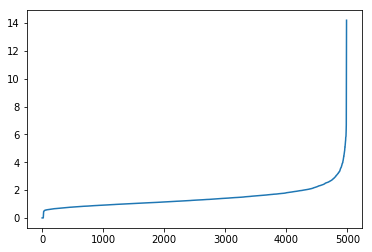

In [178]:
#plotting the distance obtained and chosing best eps using elbow method
distance1 = np.sort(d1, axis=0)
distance1 = distance1[:,1]
plt.plot(distance1)

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [179]:
# Please write all the code with proper documentation
DBSCAN_tfidfW2V = DBSCAN(eps=3)
DBSCAN_tfidfW2V.fit(tfidf_sent_vectors2_std)

predicted = DBSCAN_tfidfW2V.labels_

final['Cluster_DBSCAN_tfidfW2V'] = predicted

In [180]:
final['Cluster_DBSCAN_tfidfW2V'].value_counts()

 0    4701
-1     260
 1      15
 3       5
 2       5
Name: Cluster_DBSCAN_tfidfW2V, dtype: int64

In [184]:
len(final['Cluster_DBSCAN_tfidfW2V'].value_counts())

5

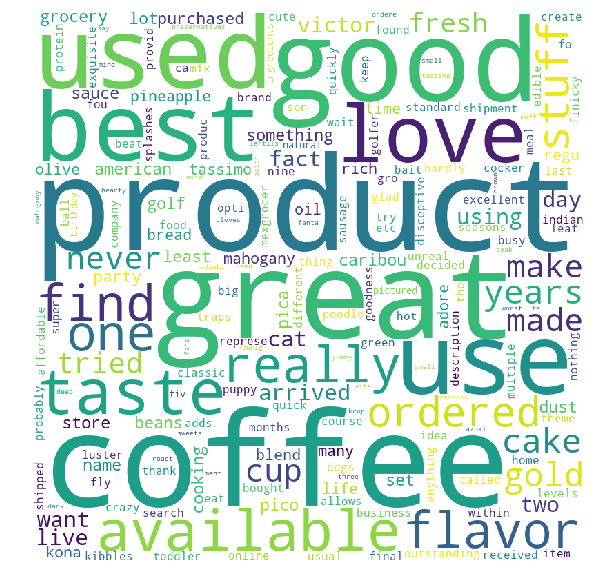

In [181]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                
                min_font_size = 10).generate(str(final.preprocessed_reviews[(final['Cluster_DBSCAN_tfidfW2V']==0)])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

# [6] Conclusions

In [182]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan

from prettytable import PrettyTable

In [191]:
x = PrettyTable(border=True)

x.field_names = ['Vectorizer','Model','Number of Clusters formed','Best no of clusters']

x.add_row(['BOW','kmeans',len(final['Predicted_cluster_BOW'].value_counts()),'8 (based on elbow curve)'])
x.add_row(['TFIDF','kmeans',len(final['Predicted_cluster_TFIDF'].value_counts()),'8 (based on elbow curve)'])
x.add_row(['AVG W2V','kmeans',len(final['Predicted_cluster_avgW2V'].value_counts()),'8 (based on elbow curve)'])
x.add_row(['TFIDF AVG W2V','kmeans',len(final['Predicted_cluster_tfidfW2V'].value_counts()),'8 (based on elbow curve)'])
x.add_row(['AVG W2V','agllomerative',len(final['Cluster_Agg_avgW2V'].value_counts()),'None(drawn wordcloud for clusters 0 and 1)'])
x.add_row(['TFIDF AVG W2V','agllomerative',len(final['Cluster_Agg_tfidfW2V'].value_counts()),'None(drawn wordcloud for clusters 3 and 1)'])
x.add_row(['AVG W2V','dbscan',len(final['Cluster_DBSCAN_avgW2V'].value_counts()),'No best cluster found(eps is chosen as 3)'])
x.add_row(['TFIDF AVG W2V','dbscan',len(final['Cluster_DBSCAN_tfidfW2V'].value_counts()),'No best cluster found(eps is chosen as 3)'])

x.align['Best no of clusters'] = 'l'
print(x)

+---------------+---------------+---------------------------+--------------------------------------------+
|   Vectorizer  |     Model     | Number of Clusters formed | Best no of clusters                        |
+---------------+---------------+---------------------------+--------------------------------------------+
|      BOW      |     kmeans    |             8             | 8 (based on elbow curve)                   |
|     TFIDF     |     kmeans    |             8             | 8 (based on elbow curve)                   |
|    AVG W2V    |     kmeans    |             8             | 8 (based on elbow curve)                   |
| TFIDF AVG W2V |     kmeans    |             8             | 8 (based on elbow curve)                   |
|    AVG W2V    | agllomerative |             2             | None(drawn wordcloud for clusters 0 and 1) |
| TFIDF AVG W2V | agllomerative |             5             | None(drawn wordcloud for clusters 3 and 1) |
|    AVG W2V    |     dbscan    |    

# Note

1. Used 5K data points to draw wordcloud for all
2. Cluster no -1 was generated in case of DBSCAN.This indicated presence of noise which couldn't be classified.
3. Special thanks to the below websites which were referenced:
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html